In [124]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from IPython.display import display

%matplotlib inline

sns.set()

# Helper functions

In [145]:
def get_best_row(group):
    idx_min_rmsse = group.rmsse.idxmin()
    return group.loc[idx_min_rmsse].drop('id_piezo')

In [126]:
def plot_best_models(result_df):
    best_models = result_df.reset_index(drop=True).groupby('id_piezo').apply(get_best_row)
    models_and_stations = best_models.join(sources)
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([-5, 10, 42, 52])

    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    sns.scatterplot(data=models_and_stations, x='x', y='y', hue='model', ax=ax) 

    ax.set_title('France');

    plt.tight_layout()
#plt.savefig('Images/plot_clusters.png')

In [144]:
def plot_stats(result_df):
    plt.figure(figsize=(8, 5))
    ax = sns.boxplot(data=result_df, y='rmsse', x='model')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yscale('log')
    plt.show()
    
    agg_metrics = result_df.groupby('model')[['rmsse']].agg(['mean', 'std']).T
    display(agg_metrics)

In [149]:
def plot_forecast(forecast_def): 

    nrows = 6
    ncols = 3

    plt.figure(figsize=(20, 20))

    for i, (index, row) in enumerate(forecast_def[['BSS_ID', 'NOM_COMMUNE']].iterrows()):
        df = forecast_def[forecast_def.index==index]
        df = df.set_index('DATE')

        ax = plt.subplot(nrows, ncols, i+1)
        df.plot(ax=ax, title=f'Piézomètre {row.BSS_ID} ({row.NOM_COMMUNE})', xlabel='')
        
        if i == 17:
            break

    plt.tight_layout()
    #plt.savefig('Images/forecasts.png')
    plt.show()

# Load stations

In [8]:
sources = pd.read_csv('../data_collection/stations.csv', delimiter=',', index_col=0)
sources.head()

,x,y,geometry,dpt,prof,alt,masse_eau,codes_bdlisa,CodeEH,InclusEH,EtatEH,NatureEH,MilieuEH,ThemeEH,OrigineEH
bss,,,,,,,,,,,,,,,
06216X0228/P30-10,3.401730,46.272865,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",03,8.0,237.20,"[""Alluvions de l'Allier aval""]",932AR01,932AR01,932AR,2,5.0,1,1.0,1.0
05373X0546/5410,-0.879629,47.059019,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",49,23.4,106.00,['Bassin versant de la Sèvre Nantaise'],181AE01,181AE01,181AE,2,6.0,2,3.0,1.0
01193X0168/FEA10,-0.488171,49.295510,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",14,30.0,13.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10396X0083/SA10,3.022001,43.209046,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",11,19.3,5.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07372X0048/F10,1.538653,45.529764,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",19,138.0,396.00,NaN,372AG03,372AG03,372AG,2,6.0,2,3.0,1.0


In [9]:
common_piezo = pd.read_csv('piezos_communs.csv').squeeze()
common_piezo.head()

0       00065X0148/P
1    00068X0010/F295
2     00127X0873/PZ1
3     00134X0127/PZ1
4      00148D0177/F2
Name: id_piezo, dtype: object

In [12]:
missing_source = set(common_piezo).difference(sources.index)
print(missing_source)

{'01258X0020/S1', '07223C0113/S', '06505X0080/FORC'}


# Load legacy results

In [49]:
result_folder = './'

files = [result_folder + 'oldTG_local_part1.csv', 
          result_folder + 'oldTG_local_part2.csv',
          result_folder + 'oldTG_local_part3.csv',
          result_folder + 'oldTG_local_part4.csv',
          result_folder + 'oldTG_local_cmpl.csv',
          result_folder + 'oldTG_local_xgb.csv']
legacy_result = pd.concat([pd.read_csv(file, delimiter='\t') for file in files])
legacy_result['rmse'] = np.sqrt(legacy_result.mse)
legacy_result = legacy_result.rename(columns={'id_method_ML': 'model'})
legacy_result = legacy_result[~legacy_result.approx_exo]
legacy_result = legacy_result[legacy_result.id_piezo.isin(common_piezo)]
legacy_result.head()

,id_piezo,model,type,r,use_exo_rain,use_exo_eto,use_exo_bdlisa,approx_exo,rmsse,mse,rmse
0,00065X0148/P,lm,Local,100.0,False,False,False,False,0.678561,0.010110,0.100549
2,00065X0148/P,lm,Local,100.0,True,False,False,False,3.557765,0.277926,0.527187
4,00065X0148/P,lm,Local,100.0,True,True,False,False,1.676050,0.061680,0.248356
6,00065X0148/P,svr,Local,100.0,False,False,False,False,2.311324,0.117299,0.342490
8,00065X0148/P,svr,Local,100.0,True,False,False,False,1.311381,0.037760,0.194319


# Load deepar results

In [62]:
deepar_result = pd.read_csv(result_folder + 'local_DeepAR.csv', index_col=0)
deepar_result = deepar_result.rename(columns={'item_id': 'id_piezo', 'use_exo_evo': 'use_exo_eto'})
deepar_result = deepar_result[deepar_result.id_piezo.isin(common_piezo)]

if 'use_exo_bdlisa' not in deepar_result.columns:
    deepar_result['use_exo_bdlisa'] = False
    
deepar_result['type'] = 'Local'
deepar_result['model'] = 'DeepAR-L'
deepar_result.head()

,id_piezo,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,...,QuantileLoss[0.9],Coverage[0.9],model,learningtime,use_exo_rain,use_exo_eto,rmse,rmsse,use_exo_bdlisa,type
0,00065X0148/P,0.086176,20.646864,78.969994,0.849140,0.069380,3.199902,0.411143,0.270092,20.047926,...,8.554083,1.000000,DeepAR-L,184.708851,False,False,0.293558,1.891262,False,Local
0,00068X0010/F295,0.565492,59.138580,2281.949951,24.537096,0.048930,12.995974,0.026238,0.025755,214.041626,...,16.547534,1.000000,DeepAR-L,177.385411,False,False,0.751992,4.633754,False,Local
0,00127X0873/PZ1,0.027925,13.217788,92.599998,0.995699,0.047984,2.961967,0.139634,0.153190,16.575527,...,6.832017,0.397849,DeepAR-L,223.069813,False,False,0.167107,2.182506,False,Local
0,00134X0127/PZ1,0.098360,27.442253,2074.350342,22.304842,0.008774,33.630008,0.013243,0.013144,215.706747,...,9.133483,1.000000,DeepAR-L,224.182392,False,False,0.313624,25.327176,False,Local
0,00148D0177/F2,0.070235,18.192642,612.430054,6.585269,0.030544,6.404472,0.031044,0.030561,42.740401,...,5.415812,1.000000,DeepAR-L,228.762483,False,False,0.265019,3.784226,False,Local


In [78]:
deepar_global_result = pd.read_csv(result_folder + 'global_DeepAR.csv', index_col=0)
deepar_global_result = deepar_global_result.rename(columns={'item_id': 'id_piezo', 'use_exo_evo': 'use_exo_eto'})
deepar_global_result = deepar_global_result[deepar_global_result.id_piezo.isin(common_piezo)]
deepar_global_result.rmsse = deepar_global_result.rmsse.astype(float)

if 'use_exo_bdlisa' not in deepar_global_result.columns:
    deepar_global_result['use_exo_bdlisa'] = False
    
deepar_global_result['type'] = 'Global'
deepar_global_result['model'] = 'DeepAR-G'
deepar_global_result.head()

,id_piezo,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,...,model,learningtime,use_exo_rain,use_exo_eto,use_exo_lisa,rmse,TN,rmsse,use_exo_bdlisa,type
1.0,00065X0148/P,0.21344613516202537,37.97240447998047,78.9699935913086,0.8491397160355763,0.06938002406281428,5.885057407104001,0.45361885973202287,0.5977699936077159,116.35105342108562,...,DeepAR-G,213.95662760734558,False,False,False,0.46200231077563386,0.024092569805963086,2.976477,False,Global
2.0,00068X0010/F295,30.224866641465052,473.3548278808594,2281.949951171875,24.537096249159948,0.048930437599828444,104.02189533967743,0.2085994392312983,0.237663576679845,2685.3804675213073,...,DeepAR-G,213.95662760734558,False,False,False,5.497714674432009,0.026336630383341237,33.876778,False,Global
11.0,00127X0873/PZ1,0.29356568859469506,46.01318359375,92.5999984741211,0.9956989083238827,0.04798390884507735,10.311069416707534,0.5025391937584005,0.7319121822234123,175.94424081877523,...,DeepAR-G,213.95662760734558,False,False,False,0.5418170250136988,0.005862423095125414,7.076428,False,Global
12.0,00134X0127/PZ1,31.809759324596776,483.9842224121094,2074.350341796875,22.304842384912636,0.00877424692351616,593.1143115927534,0.23368960554881762,0.27147572014921456,16511.137208891672,...,DeepAR-G,213.95662760734558,False,False,False,5.640014124503304,0.00015333648840511104,455.467544,False,Global
14.0,00148D0177/F2,5.181594028267809,194.40928649902344,612.4300537109375,6.585269394741263,0.030544253925661086,68.4391388495218,0.32096239315566194,0.3986343465825563,1875.9538394528665,...,DeepAR-G,213.95662760734558,False,False,False,2.2763114963176303,0.004904548656988732,32.503653,False,Global


# Load Prophet, NeuralProphet and Conv results

In [79]:
files = [result_folder + 'local_prophet.csv', 
          result_folder + 'local_neuralprophet.csv',
          result_folder + 'local_Conv.csv']
deeplearning_result = pd.concat([pd.read_csv(file, delimiter=',') for file in files])
deeplearning_result = deeplearning_result.rename(columns={'bss_code': 'id_piezo', 'rmse_test': 'rmse', 'rmsse_test': 'rmsse', 'use_exo_evo': 'use_exo_eto'})
deeplearning_result = deeplearning_result[deeplearning_result.id_piezo.isin(common_piezo)]

if 'use_exo_bdlisa' not in deeplearning_result.columns:
    deeplearning_result['use_exo_bdlisa'] = False
    
deeplearning_result['type'] = 'Local'
deeplearning_result.head()

,id_piezo,model,rmse_train,rmse,rmsse_train,rmsse,learningtime,use_exo_rain,use_exo_eto,h1,...,h86,h87,h88,h89,h90,h91,h92,h93,use_exo_bdlisa,type
4,00065X0148/P,prophet,0.308735,0.282583,2.007717,1.837651,0.702274,False,False,1.082109,...,0.763810,0.781719,0.764617,0.750875,0.745400,0.757558,0.737699,0.750746,False,Local
5,00065X0148/P,prophet,0.301175,0.258691,1.958556,1.682278,0.643840,True,False,1.131278,...,0.816696,0.836948,0.825391,0.771921,0.652766,0.714907,0.350567,0.811579,False,Local
6,00065X0148/P,prophet,0.299752,0.248236,1.949303,1.614289,0.794361,False,True,1.091117,...,0.802474,0.857490,0.826903,0.773760,0.613735,0.806678,0.731351,0.748738,False,Local
7,00065X0148/P,prophet,0.294434,0.243034,1.914715,1.580461,0.616374,True,True,1.127481,...,0.838248,0.889592,0.865493,0.786197,0.557603,0.763794,0.418859,0.796979,False,Local
8,00068X0010/F295,prophet,0.271972,1.261550,1.678213,7.784430,2.905123,False,False,24.423687,...,21.993809,21.947244,21.886258,21.856302,21.809436,21.748219,21.685697,21.647721,False,Local


# Merge every results

In [80]:
all_result = pd.concat([lagacy_result, deepar_result, deepar_global_result, deeplearning_result])

bool_cols = ['use_exo_rain', 'use_exo_eto', 'use_exo_bdlisa']
all_result[bool_cols] = all_result[bool_cols].replace(to_replace='False', value=False).astype(bool)

filter_cols = ['id_piezo', 'model', 'type', 'use_exo_rain', 'use_exo_eto', 'use_exo_bdlisa', 'rmsse', 'rmse']
all_result_filtered = all_result[filter_cols]
all_result_filtered.head()

,id_piezo,model,type,use_exo_rain,use_exo_eto,use_exo_bdlisa,rmsse,rmse
0.0,00065X0148/P,lm,Local,False,False,False,0.678561,0.100549
2.0,00065X0148/P,lm,Local,True,False,False,3.557765,0.527187
4.0,00065X0148/P,lm,Local,True,True,False,1.676050,0.248356
6.0,00065X0148/P,svr,Local,False,False,False,2.311324,0.34249
8.0,00065X0148/P,svr,Local,True,False,False,1.311381,0.194319


# Comparing without exo data

In [81]:
result_no_exo = all_result_filtered[~(all_result_filtered.use_exo_eto | all_result_filtered.use_exo_rain | all_result_filtered.use_exo_bdlisa)]

assert not result_no_exo.isna().any().any(), "There are NaN in the dataframe"

result_no_exo.groupby(['id_piezo', 'model']).count().describe() # must 1 everywhere

,type,use_exo_rain,use_exo_eto,use_exo_bdlisa,rmsse,rmse
count,10550.000000,10550.000000,10550.000000,10550.000000,10550.000000,10550.000000
mean,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000
std,0.300014,0.300014,0.300014,0.300014,0.300014,0.300014
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


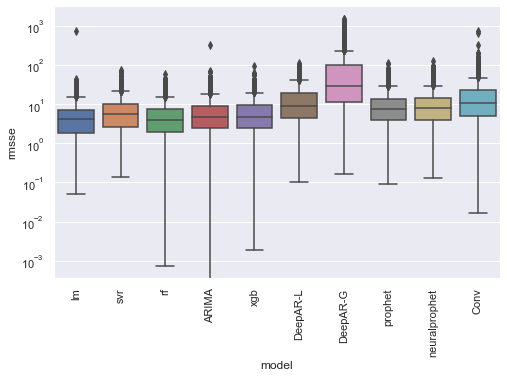

model           ARIMA       Conv    DeepAR-G   DeepAR-L         lm  \
rmsse mean   7.412144  20.430820   86.063697  14.455558   6.283703   
      std   12.526221  39.615962  151.422048  15.690428  22.627880   

model       neuralprophet    prophet        rf       svr       xgb  
rmsse mean      12.441372  11.689310  5.960052  8.057855  7.348983  
      std       14.610189  12.925451  6.512028  8.759922  8.068334

In [146]:
plot_stats(result_no_exo)

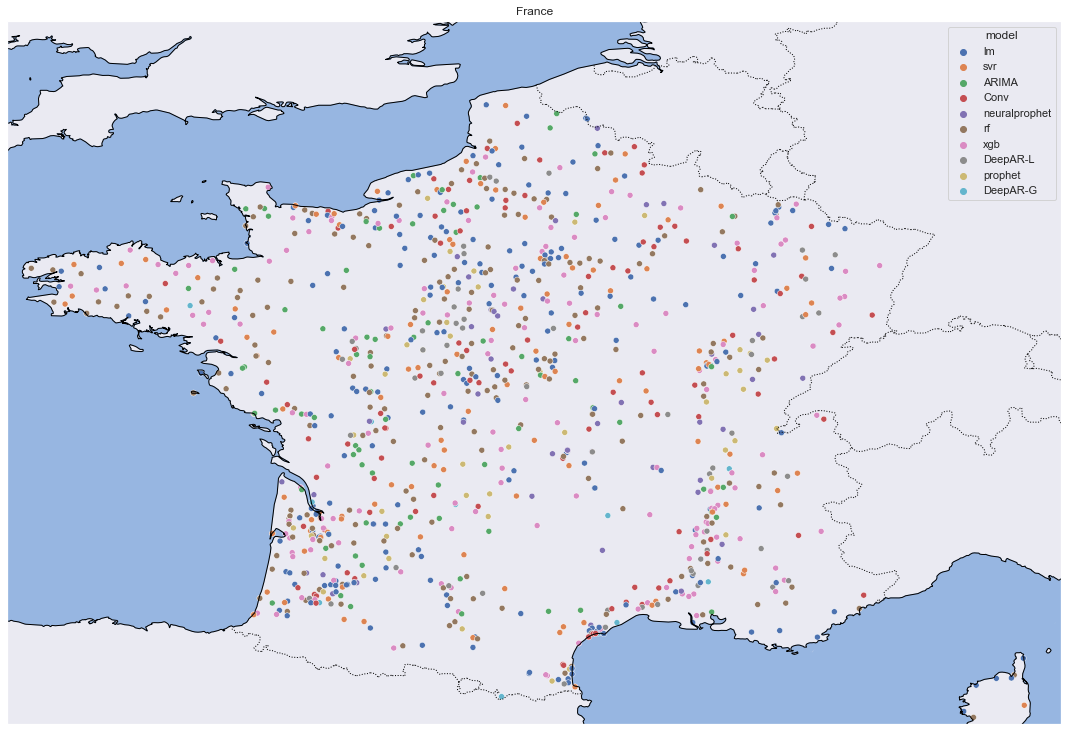

In [147]:
plot_best_models(result_no_exo)

In [150]:
models_and_stations

,model,type,use_exo_rain,use_exo_eto,use_exo_bdlisa,rmsse,rmse,x,y,geometry,...,alt,masse_eau,codes_bdlisa,CodeEH,InclusEH,EtatEH,NatureEH,MilieuEH,ThemeEH,OrigineEH
id_piezo,,,,,,,,,,,,,,,,,,,,,
00065X0148/P,lm,Local,False,False,False,0.678561,0.100549,1.817000,50.808512,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",...,115.00,"[""Craie de l'Audomarois""]",123AK03,123AK03,123AK,1,5.0,1,2.0,1.0
00068X0010/F295,svr,Local,False,False,False,0.454735,0.07166,2.092688,50.797993,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",...,55.00,"[""Craie de l'Audomarois""]",121BD01,121BD01,121BD,3,5.0,4,2.0,1.0
00127X0873/PZ1,lm,Local,False,False,False,0.543477,0.041164,2.390764,50.645836,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",...,20.00,"[""Craie de l'Artois et de la vallée de la Lys""]",121BD01,121BD01,121BD,3,5.0,4,2.0,1.0
00134X0127/PZ1,ARIMA,Local,False,False,False,1.574357,0.019532,2.819637,50.683527,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",...,15.50,['Sables du Landénien des Flandres'],119AA01,119AA01,119AA,3,5.0,1,2.0,1.0
00148D0177/F2,lm,Local,False,False,False,0.946241,0.06485,3.234083,50.618749,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",...,27.70,['Craie de la vallée de la Deûle'],121BD01,121BD01,121BD,3,5.0,4,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11064X0013/ALISO,lm,Local,False,False,False,0.425476,0.083533,9.290129,42.651455,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",...,8.00,NaN,720AD15,720AD15,720AD,2,5.0,1,1.0,1.0
11128X0125/CHIUNI,lm,Local,False,False,False,2.434042,0.231953,8.612353,42.177100,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",...,8.00,NaN,720CA11,720CA11,720CA,2,5.0,1,1.0,1.0
11156X0009/BRAVON,svr,Local,False,False,False,0.403578,0.05305,9.473112,42.263982,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",...,15.00,"[""Alluvions des fleuves côtiers de la Plaine-O...",600AE01,600AE01,600AE,3,6.0,1,2.0,1.0
